# Low-Rank Structure in Gaussian Covariances

This notebook explores how low-rank changes in Gaussian coefficient matrices affect covariance structure.
The emphasis is on empirical covariance, eigenvalues, and matrix rank.

## Background

$$
x = W z + \varepsilon,\quad z \sim \mathcal{N}(0, I_k),\quad \varepsilon \sim \mathcal{N}(0, \sigma^2 I_d)
$$

$$
\Sigma = W W^\top + \sigma^2 I_d.
$$

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigvalsh

rng = np.random.default_rng(0)

In [57]:
d = 40
k = 8
sigma = 0.1
n = 1500

W0 = rng.normal(size=(d, k))
Sigma0 = W0 @ W0.T + sigma**2 * np.eye(d)

## Low-Rank vs Diffuse Coefficient Changes

In [58]:
rank_star = 2

B = rng.normal(size=(d, rank_star))
A = rng.normal(size=(rank_star, k))
DeltaW_lr = B @ A

D = rng.normal(size=(d, k))
DeltaW_dense = D / np.linalg.norm(D, 'fro') * np.linalg.norm(DeltaW_lr, 'fro')

In [59]:
def sample(W):
    z = rng.normal(size=(n, k))
    eps = sigma * rng.normal(size=(n, d))
    return z @ W.T + eps

S_lr = (sample(W0 + DeltaW_lr).T @ sample(W0 + DeltaW_lr)) / n
S_dense = (sample(W0 + DeltaW_dense).T @ sample(W0 + DeltaW_dense)) / n

In [60]:
# Fix emprical covariance calculation

# Explanation: the issue was that the empirical covariance was computed as X1^T X2, where X1 and X2 were
# different random samples. That product is not symmetric and not guaranteed to be positive semidefinite, so the 
# resulting “covariance” can have large negative eigenvalues and an invalid spectrum.
X_lr = sample(W0 + DeltaW_lr)
S_lr = (X_lr.T @ X_lr) / n

X_dense = sample(W0 + DeltaW_dense)
S_dense = (X_dense.T @ X_dense) / n

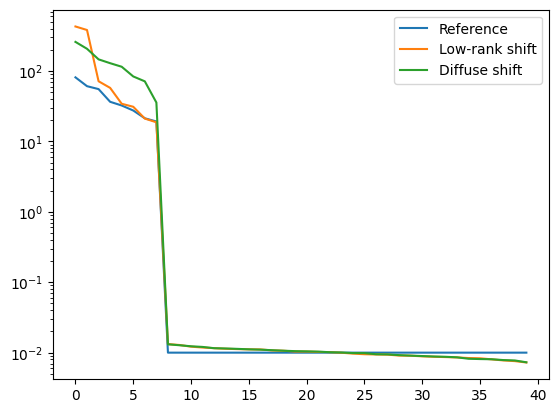

In [61]:
eig0 = eigvalsh(Sigma0)
eig_lr = eigvalsh(S_lr)
eig_dense = eigvalsh(S_dense)

plt.semilogy(eig0[::-1], label='Reference')
plt.semilogy(eig_lr[::-1], label='Low-rank shift')
plt.semilogy(eig_dense[::-1], label='Diffuse shift')
plt.legend()
plt.show()

In [62]:
# Step 1: Compute Eigenvalues

# This is a convenience cell to print out the eigenvalues. The eigenvalues have already been 
# computed above, so this cell just needs to sort them into descending order as eigvalsh 
# (https://numpy.org/devdocs/reference/generated/numpy.linalg.eigvalsh.html) returns eigenvalues in 
# ascending order and then print them out. 

eig0_desc = eig0[::-1]
eig_lr_desc = eig_lr[::-1]
eig_dense_desc = eig_dense[::-1]

print(eig0_desc)
print(eig_lr_desc)
print(eig_dense_desc)

[8.12904989e+01 6.08975763e+01 5.53590309e+01 3.65448251e+01
 3.23855431e+01 2.74706222e+01 2.13097745e+01 1.91941980e+01
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02]
[4.29114726e+02 3.82256775e+02 7.15564892e+01 5.76130117e+01
 3.42662034e+01 3.10611694e+01 2.11144812e+01 1.86947164e+01
 1.32310442e-02 1.28482508e-02 1.21606384e-02 1.18257774e-02
 1.15774816e-02 1.13529931e-02 1.12286874e-02 1.11459378e-02
 1.11082543e-02 1.07557458e-02 1.06429386e-02 1.03638815e-02
 1.03599367e-02 1.02364434e-02 1.01641057e-02 9.97826959e-03
 9.69477661e-03 9.49838

In [63]:
# Step 3: Quantify "significant change"

# We have a defined 30% fixed threshold for "significant change" for an eigenvalue compared
# to the reference eigenvalue in Sigma0 (updated from 10% which is too low as the noise threshold in Sigmo0 
# is quite low at 1.00000000e-02 and so will capture a lot of eigenvalues as significantly changed but 
# that haven't practically really changed). We compute and count how many eigenvalues in the low-rank
# and diffuse cases have changed by more than this threshold compared to the reference eigenvalues.
threshold = 0.3

rel_change_lr = np.abs(eig_lr_desc - eig0_desc) / eig0_desc
rel_change_dense = np.abs(eig_dense_desc - eig0_desc) / eig0_desc

num_sig_lr = int(np.sum(rel_change_lr > 0.3))
num_sig_dense = int(np.sum(rel_change_dense > 0.3))

print(f'# of significant eigenvalue changes in low-rank case: {num_sig_lr}')
print(f'# of significant eigenvalue changes in diffuse case: {num_sig_dense}')

# of significant eigenvalue changes in low-rank case: 4
# of significant eigenvalue changes in diffuse case: 9


In [64]:
print(len(eig0_desc)), print(len(eig_lr_desc)), print(len(eig_dense_desc))
print(rel_change_lr)
print(rel_change_dense)


40
40
40
[4.27878082e+00 5.27704415e+00 2.92589267e-01 5.76502598e-01
 5.80709817e-02 1.30704983e-01 9.16449386e-03 2.60225333e-02
 3.23104417e-01 2.84825083e-01 2.16063841e-01 1.82577738e-01
 1.57748162e-01 1.35299307e-01 1.22868739e-01 1.14593785e-01
 1.10825433e-01 7.55745758e-02 6.42938593e-02 3.63881477e-02
 3.59936666e-02 2.36443370e-02 1.64105661e-02 2.17304080e-03
 3.05223389e-02 5.01610293e-02 5.76020410e-02 6.33082532e-02
 9.08238143e-02 9.50213403e-02 1.13545856e-01 1.26041074e-01
 1.34595104e-01 1.44905710e-01 1.61621450e-01 1.68647162e-01
 1.96700748e-01 2.24048303e-01 2.41813164e-01 2.74845496e-01]
[2.18874732 2.39668528 1.6447736  2.53459338 2.55075804 2.04750364
 2.34727918 0.85894748 0.31354927 0.2737589  0.2318302  0.20567007
 0.15645178 0.14620342 0.13161534 0.11491058 0.10301824 0.08371817
 0.06529192 0.05025642 0.04305692 0.03453834 0.01418019 0.00417724
 0.01356226 0.01477527 0.05140744 0.05587232 0.0778793  0.09283214
 0.1053812  0.11817601 0.12664309 0.14151049 

## Step 4: Interpret the results

**1. Low-rank case:** With a 30% threshold, only 3 eigenvalues change substantially. That’s on the same scale as the rank of the modification (rank_star = 2), which makes sense as a rank‑r update can only inject or rotate variance along about r new geometric directions, so only a few eigenvalues shift a lot.

**2. Diffuse case:** In the diffuse update, 9 eigenvalues change a lot even though the Frobenius norm matches the low‑rank change. The reason is that a dense, full‑rank perturbation spreads its effect across many variance directions, so more eigenvalues move noticeably.

**3.:** Eigenvalues describe variance along orthogonal geometric directions. A low‑rank change can only affect a small number of those directions (and thus a small number of eigenvalues), while a diffuse change touches many directions and shifts more of the spectrum. This is exactly how matrix rank limits how many variance directions can change.


### Note on the usage of AI in this assignment:

I used AI only to clarify and explain the conceptual background (such as matrix rank, covariance spectra, and variance directions amongst others) as provided in the assignment and to help me understand the module material. It did not provide solutions, code, or answers for the assignment tasks, and I completed the analysis and implementation myself.